<div style="text-align: right">AI workshop at Northeastern with EM Lyon Business School</div>
<div style="text-align: right">Zixiao Wang , 24 November 2019, with material from Arthur Juliani</div>

# Q-Learning

In this notebook, the context introduces the basic Q-Learning and Q-Learning with neural network.

We will need an algorithm that learns long-term expected rewards. This is exactly what Q-Learning is designed to provide.

## The problem

We are going to solve the problem : [Frozen Lake](https://gym.openai.com/envs/FrozenLake-v0/)

### Basic Q-Learning

In it’s simplest implementation, Q-Learning is a table of values for every state (row) and action (column) possible in the environment. Within each cell of the table, we learn a value for how good it is to take a given action within a given state. In the case of the FrozenLake environment, we have 16 possible states (one for each block), and 4 possible actions (the four directions of movement), giving us a 16x4 table of Q-values. We start by initializing the table to be uniform (all zeros), and then as we observe the rewards we obtain for various actions, we update the table accordingly.

We make updates to our Q-table using something called the [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation)(Value function), which states that the expected long-term reward for a given action is equal to the immediate reward from the current action combined with the expected reward from the best future action taken at the following state. In this way, we reuse our own Q-table when estimating how to update our table for future actions! In equation form, the rule looks like this:

<div style="text-align: center">
    Eq 1. Q(s,a) = r + γ(max(Q(s’,a’))
</div>

This says that the Q-value for a given state (s) and action (a) should represent the current reward (r) plus the maximum discounted (γ) future reward expected according to our own table for the next state (s’) we would end up in. The discount variable allows us to decide how important the possible future rewards are compared to the present reward. By updating in this way, the table slowly begins to obtain accurate measures of the expected future reward for a given action in a given state.

### Q-Learning with neural network

While it is easy to have a 16x4 table for a simple grid world, the number of possible states in any modern game or real-world environment is nearly infinitely larger. For most interesting problems, tables simply don’t work. We instead need some way to take a description of our state, and produce Q-values for actions without a table: that is where neural networks come in. By acting as a [**value function approximator**](https://zhuanlan.zhihu.com/p/21421729), we can take any number of possible states that can be represented as a vector and learn to map them to Q-values.

In the case of the FrozenLake example, we will be using a one-layer network which takes the state encoded in a one-hot vector (1x16), and produces a vector of 4 Q-values, one for each action. Such a simple network acts kind of like a glorified table, with the network weights serving as the old cells. The key difference is that we can easily expand the Tensorflow network with added **layers**, **activation functions**, and different input types, whereas all that is impossible with a regular table. The method of updating is a little different as well. Instead of directly updating our table, with a network we will be using [**backpropagation**](https://www.jiqizhixin.com/graph/technologies/7332347c-8073-4783-bfc1-1698a6257db3) and a [**loss function**](https://mp.weixin.qq.com/s?__biz=MzI0ODcxODk5OA==&mid=2247498041&idx=2&sn=8c01ea8cf1ae24cbfbc29c67d3a631ab&scene=0#wechat_redirect). Our loss function will be **sum-of-squares loss**, where the difference between the current predicted Q-values, and the “target” value is computed and the gradients passed through the network. In this case, our Q-target for the chosen action is the equivalent to the Q-value computed in equation 1 above.

<div style="text-align: center">
Eq2. Loss = ∑(Q-target - Q)²
</div>

# Implement

### Basic Q-Learning

![](https://miro.medium.com/max/1280/0*Lhkz5Oe3aC7B-v15.)

In [3]:
import gym
import numpy as np

### 1. Load the environment

In [21]:
env = gym.make("FrozenLake-v0")
env.reset()
for _ in range(10):
    env.render()
    env.step(env.action_space.sample()) # take a random action


SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG


### 2. Implement Q-Table learning algorithm

In [5]:
env.observation_space

Discrete(16)

In [33]:
print(env.action_space)

Discrete(4)


In [40]:
%%time
#Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
lr = .8
y = .95
num_episodes = 4000
#create lists to contain total rewards and steps per episode
rList = []
for i in range(num_episodes):
    #Reset environment and get first new observation
    s = env.reset()
    totalReward = 0
    d = False
    j = 0
    #The Q-Table learning algorithm
    while j < 99:
        j+=1
        # Pi function: Choose an action by greedily (with noise) picking from Q table
        a = np.argmax(Q[s,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        #Get new state and reward from environment
        s1,r,d,_ = env.step(a)
        # Value function Bellman equation: Update Q-Table with new knowledge
        # Q(s,a) = r + γ(max(Q(s’,a’))
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        totalReward += r
        s = s1
        if d == True:
            break
    rList.append(totalReward)

Wall time: 3.31 s


In [38]:
print("Score over time(the probability to achieve the goal): " +  str(sum(rList)/num_episodes))

Score over time(the probability to achieve the goal): 0.59725


In [16]:
print("Final Q-Table Values")
print(Q)

Final Q-Table Values
[[3.34868210e-01 5.17305972e-03 7.60470859e-03 1.50159926e-02]
 [1.27468297e-03 5.49072015e-03 2.31130152e-03 2.12397602e-01]
 [4.41567019e-03 1.94811013e-01 2.07678607e-03 3.67127151e-03]
 [0.00000000e+00 3.32709013e-03 3.32164955e-03 1.17708745e-01]
 [3.98845086e-01 3.39496135e-03 3.60225848e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [3.20857972e-04 2.61323547e-13 2.71071447e-04 2.41699366e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.33703445e-03 2.14842271e-03 7.37975077e-04 3.00640941e-01]
 [0.00000000e+00 6.59951835e-01 0.00000000e+00 0.00000000e+00]
 [2.50836985e-01 0.00000000e+00 1.14805984e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.69735947e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.60832982e-01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.

---

### Q-Learning with neural network

In [71]:
import gym
import numpy as np
import random
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Disable tf2 and use tf1
tf.disable_v2_behavior()

### 1. Load the environment

In [72]:
env = gym.make("FrozenLake-v0")

### 2. Implement Network

In [73]:
# Clears the default graph stack and resets the global default graph.
tf.reset_default_graph() # This one was out of date.
# tf.compat.v1.reset_default_graph()

In [77]:
#These lines establish the feed-forward part of the network used to choose actions
# Inserts a placeholder for a tensor that will be always fed.
# 在TensorFlow 1.X中，创建占位符并在tf.Session实例化时为其提供实际值。但是，
# 从TensorFlow2.0开始，默认情况下启用了Eager Execution，因此“占位符”的概念没有意义，因为操作是立即计算的（而不是与旧范例不同）。
inputs1 = tf.placeholder(shape=[1,16],dtype=tf.float32) # This one was out of date.
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
# For vectors, use axis = 0.
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

### 3. Train the network

* [Session.run](https://www.tensorflow.org/api_docs/python/tf/compat/v1/Session#run)
* [np.identity](https://docs.scipy.org/doc/numpy/reference/generated/numpy.identity.html)

In [85]:
print({inputs1:np.identity(16)[s:s+1]})

{<tf.Tensor 'Placeholder_4:0' shape=(1, 16) dtype=float32>: array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])}


In [98]:
np.random.rand(1)

array([0.18498734])

In [106]:
env.action_space.sample()

2

In [79]:
init = tf.initialize_all_variables()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
#create lists to contain total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        s = env.reset()# 0 
        rAll = 0
        d = False
        j = 0
        #The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print ("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Percent of succesful episodes: 0.4355%


### 4. Some statistics on network performance

We can see that the network beings to consistly reach the goal around the 750 episode mark.

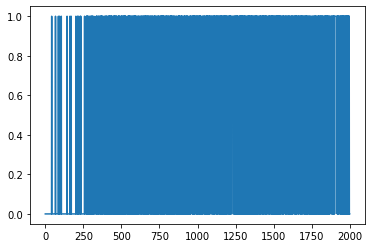

In [80]:
plt.plot(rList)


It also begins to progress through the environment for longer than chance aroudn the 750 mark as well.

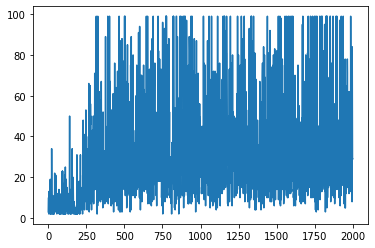

In [81]:
plt.plot(jList)

### Keras implement

In [ ]:
import tensorflow as tf

from tensorflow import keras